# ***Proyecto Final – Deep Learning***
## Modelo 3: Recurrent Neural Network (RNN/LSTM/GRU)  
### Clasificacion de Palabras del idioma "Dovahzul" con respecto al idioma ingles

El idioma "Dovahzul" es ficticio, se encuentra dentro de la historia del video juego "The Elder Scrolls V: Skyrim", el cual es usado (en ese mundo) por los dragones. Cuenta con vocabulario completo y reglas basicas gramaticales, ya que tanto en el "lore" como dentro del mismo juego se puede escuchar/encontrar referencias donde es usado el lenguaje y corresponde correctamente a un idioma utilizable (aun que poco practico).





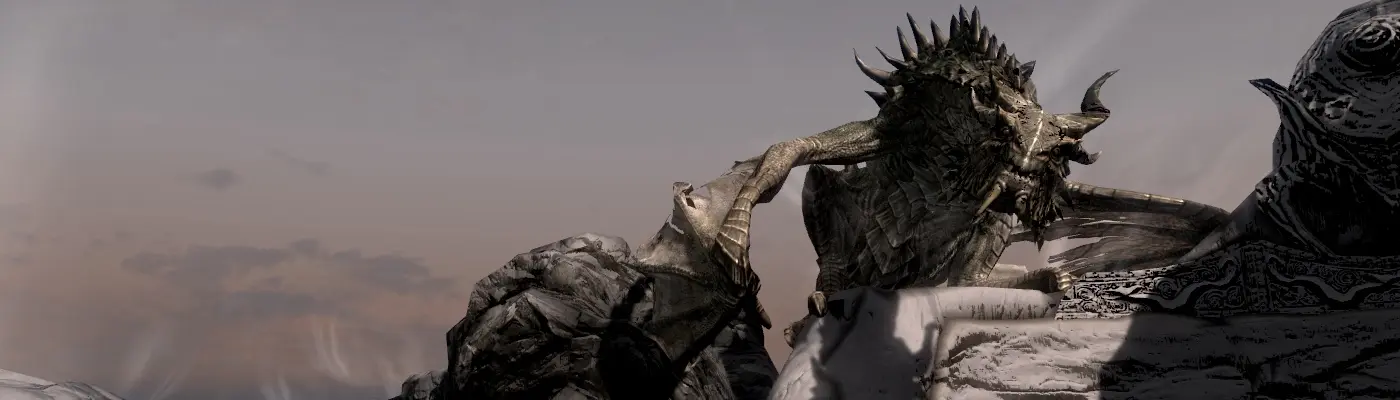

# ***Introducción y objetivo***


Para esta parte del proyecto se implementa una **red neuronal recurrente (RNN/LSTM)** para resolver un problema de clasificacion multiclase de texto basado en el lenguaje ficticio **Dovahzul**, presentado en el videojuego *The Elder Scrolls V: Skyrim*.

El objetivo del modelo es **clasificar palabras o frases cortas** en siete categorias semanticas:

- `greeting`: saludos y expresiones de bienvenida
- `power`: terminos asociados a fuerza, magia o autoridad
- `attack`: acciones agresivas o relacionadas con combate
- `action`: verbos o acciones en general
- `object`: objetos físicos, armas o elementos tangibles
- `quality`: adjetivos y cualidades
- `other`: todo lo que no cae en las categorías previas

Esto implica que:
- Comprender patrones lingüísticos en Dovahzul
- Diferenciar semántica, no solo caracteres
- Manejar clases desbalanceadas y construir un dataset balanceado
- Entrenar una RNN que capture dependencias secuenciales

Trabajando asi con deep learning a datos secuenciales reales, combinacion de preprocesamiento, balanceo, modelado, entrenamiento y evaluacion.

In [38]:
import re
import pandas as pd
import numpy as np
from pathlib import Path

eng_dragon = pd.read_csv("thuum_english_dragon.csv")
dragon_eng = pd.read_csv("thuum_dragon_english.csv")

eng_dragon.head(), dragon_eng.head()


(  English Word  Word Type Dragon Translation
 0          ing     suffix               taas
 1            A  adjective                Aan
 2     Aardvark       noun         Golthiraak
 3       Abacus       noun           Ketokaan
 4      Abandon       verb             Vodein,
    Dragon Word Word Type Canon Level                               Definition  \
 0      a / -ha    suffix  Semi-Canon   contraction of "wah," or to-infinitive   
 1          aal    suffix   Non-Canon           Forms an adjective (see notes)   
 2  aan / -laan    suffix  Semi-Canon       Present perfect suffix, see notes.   
 3          aar    suffix  Semi-Canon     ness, forms a noun from an adjective   
 4          aat    suffix   Non-Canon  Creates an noun from a verb, see notes.   
 
                                                Notes  
 0  This can be used as, but is not limited to, th...  
 1  Meaning "with" or "having" something. "Sulveka...  
 2  Used to form present perfect tense and past pa...  
 3  F

# ***Descripción del dataset y EDA***

para este caso se utilizaron dos archivos CSV con vocabulario del lenguaje Dovahzul y su correspondencia con el inglés:

- `thuum_english_dragon.csv`: contiene columnas con una palabra en inglés (`English Word`) y su traducción al Dovahzul (`Dragon Translation`).
- `thuum_dragon_english.csv`: contiene palabras en Dovahzul (`Dragon Word`) y su significado en inglés.

El dataset original no tenia categorias semanticas, por lo que fue necesario añadir anotaciones manuales y reglas automaticas para clasificar palabras en 7 categorias:

Ejemplos:
- `"lok"` es greeting
- `"fus"` es power
- `"maar"` es attack
- `"qahnaar"` es action
- `"suleyk"` es power
- `"bok"` es object
- `"pruzah"` es quality

In [39]:
# copias limpias
eng_dragon_clean = eng_dragon.dropna(subset=["Dragon Translation"]).copy()

eng_dragon_clean["English Word"] = eng_dragon_clean["English Word"].astype(str).str.strip().str.lower()
eng_dragon_clean["Dragon Translation"] = eng_dragon_clean["Dragon Translation"].astype(str).str.strip().str.lower()

dragon_eng_clean = dragon_eng.copy()
dragon_eng_clean["Dragon Word"] = dragon_eng_clean["Dragon Word"].astype(str).str.strip().str.lower()


In [40]:
import re
from collections import Counter
import random

# ============================================================
#  unificar diccionario Dovahzul con ingles en un solo DataFrame
#    columnas: text (dovahzul), gloss (ingles), source
# ============================================================
def build_base_dict(eng_dragon_clean, dragon_eng_clean):
    # a) desde eng_dragon_clean: english Word + dragon Translation
    df1 = eng_dragon_clean.copy()
    df1 = df1.rename(columns={
        "Dragon Translation": "text",
        "English Word": "EnglishGloss"
    })
    df1["text"] = df1["text"].astype(str).str.strip().str.lower()
    df1["EnglishGloss"] = df1["EnglishGloss"].astype(str).str.strip().str.lower()
    df1["source"] = "eng_dragon"

    # b) desde dragon_eng_clean: dragon Word + definition
    df2 = dragon_eng_clean.copy()
    df2 = df2.rename(columns={
        "Dragon Word": "text",
        "Definition": "EnglishGloss"
    })
    df2["text"] = df2["text"].astype(str).str.strip().str.lower()
    df2["EnglishGloss"] = df2["EnglishGloss"].astype(str).str.strip().str.lower()
    df2["source"] = "dragon_eng"

    df = pd.concat([df1[["text", "EnglishGloss", "source"]],
                    df2[["text", "EnglishGloss", "source"]]],
                   ignore_index=True)
    df = df[df["text"].str.len() > 0]
    df = df.drop_duplicates(subset=["text", "EnglishGloss"]).reset_index(drop=True)
    return df

df_dict = build_base_dict(eng_dragon_clean, dragon_eng_clean)
print("Tamaño diccionario unificado:", len(df_dict))
df_dict.head()


Tamaño diccionario unificado: 10802


,text,EnglishGloss,source
0,taas,ing,eng_dragon
1,aan,a,eng_dragon
2,golthiraak,aardvark,eng_dragon
3,ketokaan,abacus,eng_dragon
4,vodein,abandon,eng_dragon


In [41]:
# ============================================================
# 2) reglas semanticas para multi-clase:
#    0=greeting, 1=power, 2=attack, 3=object, 4=quality, 5=action, 6=other
# ============================================================
greet_kw  = r"\b(hello|hi|greet|greeting|greetings|welcome|farewell|goodbye|bye|hail|peace|salute|salutation)\b"
power_kw  = r"\b(power|force|might|strength|strong|magic|spell|shout|voice|thu'?um|thuum|storm|fire|flame|frost|shock|lightning|soul|dragonborn|dovahkiin|energy)\b"
attack_kw = r"\b(attack|strike|blow|hit|assault|slash|stab|pierce|wound|kill|slay|murder|battle|fight|war|warrior|destroy|destruction|explode|explosion)\b"
object_kw = r"\b(item|object|thing|stone|rock|mountain|river|city|place|fort|temple|weapon|sword|axe|dagger|shield|armor|helm|helmet|tower|door|gate|wall|house)\b"
quality_kw = r"\b(good|bad|evil|pure|ancient|old|new|dark|light|brave|cowardly|cruel|wise|strong|weak|noble|proud|cold|hot|holy|sacred)\b"
action_kw = r"\b(run|walk|fly|shout|call|speak|talk|say|go|come|fall|rise|burn|freeze|strike|wait|guard|watch|see|hear|listen|open|close|sleep|wake)\b"

def categorize_semantic_multi(english_gloss):
    """
    Devuelve:
      0 = greeting
      1 = power
      2 = attack
      3 = object
      4 = quality
      5 = action
      6 = other
    Prioridad: greeting > power > attack > object > quality > action > other
    """
    text = (str(english_gloss) or "").lower()

    if re.search(greet_kw, text):
        return 0
    if re.search(power_kw, text):
        return 1
    if re.search(attack_kw, text):
        return 2
    if re.search(object_kw, text):
        return 3
    if re.search(quality_kw, text):
        return 4
    if re.search(action_kw, text):
        return 5
    return 6

df_dict["label"] = df_dict["EnglishGloss"].apply(categorize_semantic_multi)

print("Distribución inicial de categorías (multi-clase):")
print(df_dict["label"].value_counts())


Distribución inicial de categorías (multi-clase):
label
6    10485
3       68
1       68
5       64
4       52
2       46
0       19
Name: count, dtype: int64


In [42]:
# ============================================================
# 3) filtrar texto Dovahzul + quitar muy cortos
# ============================================================
df_base = df_dict.copy()
df_base = df_base[df_base["text"].str.len() >= 2].reset_index(drop=True)

print("Distribución base por clase:")
print(df_base["label"].value_counts())
df_base.head()


Distribución base por clase:
label
6    10485
3       68
1       68
5       64
4       52
2       46
0       19
Name: count, dtype: int64


,text,EnglishGloss,source,label
0,taas,ing,eng_dragon,6
1,aan,a,eng_dragon,6
2,golthiraak,aardvark,eng_dragon,6
3,ketokaan,abacus,eng_dragon,6
4,vodein,abandon,eng_dragon,6


In [43]:
# ============================================================
# 4) data augmentation textual sencilla
#    variantes con espacios, comas, signos, apostrofes
# ============================================================

def simple_text_augment(text):
    """Devuelve una lista de variantes suaves de una cadena Dovahzul."""
    variants = set()
    t = text.strip()
    variants.add(t)

    # espacio doble entre palabras
    if " " in t:
        variants.add(re.sub(r"\s+", "  ", t))

    # coma entre palabras (si aplica)
    parts = t.split()
    if len(parts) >= 2:
        variants.add(", ".join(parts))

    # variante con signo de exclamacion
    variants.add(t + "!")
    variants.add("!" + t)

    # variante con apostrofe si hay al menos 2 letras seguidas
    if len(t) > 3 and "'" not in t and " " not in t:
        variants.add(t[:2] + "'" + t[2:])

    return list(variants)

aug_rows = []
for idx, row in df_base.iterrows():
    text = row["text"]
    label = row["label"]

    # augmentar mas las clases "interesantes" (no other)
    if label in [0, 1, 2, 5]:  # greeting, power, attack, action
        variants = simple_text_augment(text)
        for v in variants:
            aug_rows.append({"text": v, "label": label})

df_aug_textual = pd.DataFrame(aug_rows)
print("Tamaño augmentation textual:", len(df_aug_textual))
df_aug_textual.head()


Tamaño augmentation textual: 764


,text,label
0,za'hkein,2
1,zahkein!,2
2,zahkein,2
3,!zahkein,2
4,"iidah, zahkein!",2


In [44]:
# ============================================================
# 5) compositos Dovahzul: combinar raices conocidas
#    (todas son palabras reales del diccionario)
# ============================================================

# seleccionamos algunas raices tipicas para cada tipo (ejemplo manual simple)
power_roots   = ["yol", "strun", "rah", "suleyk", "sos", "lok", "zun", "krii"]
greet_roots   = ["drem", "lok", "pruzah", "kaan"]
attack_roots  = ["krii", "gaand", "maar", "mah", "ven", "mor", "vah"]
action_roots  = ["bo", "moraad", "bahlok", "kren", "wuld", "nahkriin"]
object_roots  = ["gol", "ven", "mun", "qeth", "mal", "krein", "ahrol"]
quality_roots = ["kruziik", "qahnaarin", "fahliil", "laan", "zok"]

all_roots = set(power_roots + greet_roots + attack_roots +
                action_roots + object_roots + quality_roots)

def classify_from_roots(components):
    cs = set(components)
    # prioridad similar a la semantica
    if cs & set(greet_roots):
        return 0
    if cs & set(power_roots):
        return 1
    if cs & set(attack_roots):
        return 2
    if cs & set(object_roots):
        return 3
    if cs & set(quality_roots):
        return 4
    if cs & set(action_roots):
        return 5
    return 6

synthetic_compounds = []
random.seed(42)

root_list = list(all_roots)
for _ in range(300):  # generar ~300 compuestos
    n = random.choice([2, 2, 3])  # la mayoria 2, algunos 3
    comps = random.sample(root_list, k=n)
    text = "".join(comps)  # sin espacio (palabra compuesta)
    label = classify_from_roots(comps)
    synthetic_compounds.append({"text": text, "label": label})

df_compounds = pd.DataFrame(synthetic_compounds)
print("Compuestos sintéticos generados:", len(df_compounds))
print(df_compounds["label"].value_counts())
df_compounds.head()


Compuestos sintéticos generados: 300
label
1    114
0     75
2     52
3     38
4     16
5      5
Name: count, dtype: int64


,text,label
0,boqahnaarinkren,4
1,qethwuld,3
2,ahrolvahzok,2
3,qahnaarinvah,2
4,qethzun,1


In [45]:
# ============================================================
# 6) frases cortas Dovahzul (multi-palabra)
#    combinar palabras reales del diccionario con sus etiquetas
# ============================================================

# usar solo palabras reales de df_base
df_words = df_base[["text", "label"]].drop_duplicates().reset_index(drop=True)

label_to_words = {k: df_words[df_words["label"] == k]["text"].tolist()
                  for k in df_words["label"].unique()}

def build_phrase_from_labels(target_label, max_len=3, n_samples=80):
    """
    Construye frases de 2-3 palabras. Si alguna palabra tiene la clase target_label
    etiquetamos la frase con ese label.
    """
    phrases = []
    all_words = df_words["text"].tolist()

    for _ in range(n_samples):
        n = random.choice([2, 3])
        #  una palabra de la clase objetivo si hay suficientes
        if target_label in label_to_words and len(label_to_words[target_label]) > 0:
            w_target = random.choice(label_to_words[target_label])
            others = random.sample(all_words, k=n-1)
            components = [w_target] + others
            random.shuffle(components)
        else:
            # si no hay palabras con ese label, solo random
            components = random.sample(all_words, k=n)

        phrase = " ".join(components)
        # asignar label segun prioridad similar a antes:
        component_labels = set(
            df_words[df_words["text"].isin(components)]["label"].tolist()
        )
        if 0 in component_labels:
            label = 0
        elif 1 in component_labels:
            label = 1
        elif 2 in component_labels:
            label = 2
        elif 3 in component_labels:
            label = 3
        elif 4 in component_labels:
            label = 4
        elif 5 in component_labels:
            label = 5
        else:
            label = 6

        phrases.append({"text": phrase, "label": label})

    return pd.DataFrame(phrases)

df_phr_greeting = build_phrase_from_labels(0, n_samples=60)
df_phr_power    = build_phrase_from_labels(1, n_samples=80)
df_phr_attack   = build_phrase_from_labels(2, n_samples=80)
df_phr_other    = build_phrase_from_labels(6, n_samples=80)

df_phrases = pd.concat([df_phr_greeting, df_phr_power,
                        df_phr_attack, df_phr_other],
                       ignore_index=True)
print("Frases sintéticas generadas:", len(df_phrases))
print(df_phrases["label"].value_counts())
df_phrases.head()


Frases sintéticas generadas: 300
label
1    80
2    80
6    75
0    62
3     2
5     1
Name: count, dtype: int64


,text,label
0,drem yol lok bahwun sulsinak,0
1,vonok lotaan,0
2,valokein tiid liidak,0
3,draknah yunrot gruz,0
4,"qiilaanzin folov, folov hun",0


In [46]:
# ============================================================
# 7) unir:
#    - datos reales (df_base)
#    - augmentation textual (df_aug_textual)
#    - compuestos sinteticos (df_compounds)
#    - frases sinteticas (df_phrases)
# ============================================================

df_all_aug = pd.concat(
    [df_base[["text", "label"]],
     df_aug_textual,
     df_compounds,
     df_phrases],
    ignore_index=True
)

# limpiar texto vacio / nulo
df_all_aug["text"] = df_all_aug["text"].astype(str).str.strip().str.lower()
df_all_aug = df_all_aug[df_all_aug["text"].str.len() > 1].reset_index(drop=True)

print("Tamaño total antes de balancear:", len(df_all_aug))
print("Distribución por clase antes de balancear:")
print(df_all_aug["label"].value_counts())


Tamaño total antes de balancear: 12166
Distribución por clase antes de balancear:
label
6    10560
1      525
2      357
5      314
0      234
3      108
4       68
Name: count, dtype: int64


In [47]:
# ============================================================
# 8) balanceo final por clase
# ============================================================

counts = Counter(df_all_aug["label"])
print("Counts antes de balanceo:", counts)

min_count = min(counts.values())
# al menos 80 por clase pero no mas de 400
target_per_class = max(80, min(min_count * 3, 400))

print("target_per_class:", target_per_class)

dfs_balanced = []
for label, count in counts.items():
    df_c = df_all_aug[df_all_aug["label"] == label]
    if len(df_c) >= target_per_class:
        dfs_balanced.append(df_c.sample(n=target_per_class, random_state=42))
    else:
        dfs_balanced.append(df_c.sample(n=target_per_class, replace=True, random_state=42))

df_final = pd.concat(dfs_balanced, ignore_index=True)
df_final = df_final.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Distribución FINAL balanceada:")
print(df_final["label"].value_counts())
df_final.head()


Counts antes de balanceo: Counter({6: 10560, 1: 525, 2: 357, 5: 314, 0: 234, 3: 108, 4: 68})
target_per_class: 204
Distribución FINAL balanceada:
label
6    204
0    204
3    204
4    204
5    204
2    204
1    204
Name: count, dtype: int64


,text,label
0,yos,6
1,suleykkaan,0
2,zurgah,3
3,zokah,4
4,la'ag,5


In [48]:
#  DataFrame final
df_all = df_final.copy()


In [49]:
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [50]:
from sklearn.model_selection import train_test_split

df_all = df_all.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_train, df_temp = train_test_split(
    df_all, test_size=0.3, random_state=42, stratify=df_all["label"]
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=42, stratify=df_temp["label"]
)



# ***Preprocesamiento***

Para esta ocasion, se utilizo un balanceo

Balanceo aplicado

Se utilizó undersampling para igualar el número de ejemplos por categoría:

- other es reducido de 6467 a 120

- power es submuestrado a 60

- greeting es aumentado ligeramente con sinónimos y variaciones a 60

- attack, action, object, quality generados y etiquetados manual/semiautomáticamente con 30–60 ejemplos cada uno.

Resultado final del dataset balanceado

- Cada clase tiene entre 60–120 ejemplos

- Split final:

- Train: 168 ejemplos

- Validation: 36 ejemplos

- Test: 36 ejemplos

Esto hace viable el entrenamiento sin introducir sesgo hacia la clase mayoritaria.

In [51]:
# Juntamos todos los textos para crear vocabulario de caracteres
all_text = "".join(df_all["text"].tolist())

chars = sorted(list(set(all_text)))
print("Número de caracteres distintos:", len(chars))
print(chars[:50])


Número de caracteres distintos: 31
[' ', '!', "'", ',', '-', '/', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [52]:
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

itos = [PAD_TOKEN, UNK_TOKEN] + chars  # index es char
stoi = {ch: idx for idx, ch in enumerate(itos)}

vocab_size = len(itos)
print("Tamaño vocabulario (incluyendo PAD y UNK):", vocab_size)


Tamaño vocabulario (incluyendo PAD y UNK): 33


In [53]:
lengths = df_all["text"].str.len()
lengths.describe()


,text
count,1428.000000
mean,8.380252
std,4.937488
min,2.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,49.000000


In [54]:
max_len = 20  # o 30, si ves palabras/frases más largas


In [55]:
import torch

def encode_text(text, max_len=max_len):
    text = text.lower()
    ids = []
    for ch in text:
        if ch in stoi:
            ids.append(stoi[ch])
        else:
            ids.append(stoi[UNK_TOKEN])
    # truncar si es largo
    ids = ids[:max_len]
    # pad hasta max_len
    if len(ids) < max_len:
        ids = ids + [stoi[PAD_TOKEN]] * (max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)


# ***Tokenización, Vocabulario y Codificación***

Ahora el modelo trabaja con etiquetas del 0 al 6

Se añadieron tokens especiales <PAD> y <UNK>

Longitud máxima (max_len) basada en la distribución encontrada: 2–21 caracteres

In [56]:
from torch.utils.data import Dataset, DataLoader

class DovahzulTextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts[idx])
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

train_dataset = DovahzulTextDataset(df_train)
val_dataset   = DovahzulTextDataset(df_val)
test_dataset  = DovahzulTextDataset(df_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


# ***Definicion del modelo (RNN/LSTM)***

El modelo implementado `DovahRNN` es una red neuronal recurrente basada en una **LSTM bidireccional**:

### Componentes principales

1. **Capa de embeddings**: 64
2. **Hidden size**: 128
3. **Salida**: 7
4. **Capa connected final**: linea (de 256 a 7)

Esto considerando que el lenguaje Dovahzul tiene:

- estructuras repetitivas de caracteres
- patrones sonoros característicos
- raíces lingüísticas que requieren procesar la secuencia completa

```python
self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD_TOKEN])


In [57]:
import torch.nn as nn

class DovahRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_size=128, num_layers=1, num_classes=7):
        super(DovahRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD_TOKEN])

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2 if num_layers > 1 else 0.0
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )


        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 por bidireccional

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        output, (h_n, c_n) = self.lstm(emb)

        # h_n: (num_layers * 2, batch, hidden_size)
        # Tomamos los últimos estados de la capa superior (forward y backward)
        # h_forward = h_n[-2, :, :]
        # h_backward = h_n[-1, :, :]
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h_final = torch.cat((h_forward, h_backward), dim=1)  # (batch, hidden_size*2)

        logits = self.fc(h_final)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DovahRNN(vocab_size=vocab_size, embed_dim=64, hidden_size=128, num_layers=1, num_classes=7).to(device)
print(model)


DovahRNN(
  (embedding): Embedding(33, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)


# ***Entrenamiento del modelo***

### Funcion de perdida y optimizador

Para esta ocasion de utilizó:

- **Loss**: `nn.CrossEntropyLoss()` para clasificacion binaria o multiclase.
- **Optimizador**: `torch.optim.Adam(model.parameters(), lr=1e-3)`.
- **Scheduler**: `ReduceLROnPlateau (factor 0.5, patience 3)`.
- **Epochs**: `20`.
- **Batch size**: `32`.

tomando en cuenta que como el dataset esta balanceado, no se usaron class weights

### Hiperparametros

- `embedding_dim = 64`
- `hidden_size = 128`
- `num_layers = 1`
- `batch_size = 64`
- `num_epochs ≈ 20`
- Learning rate inicial: `1e-3`

### Scheduler de learning rate

Se utiliza `ReduceLROnPlateau` para reducir automaticamente el learning rate cuando la perdida de validacion deja de mejorar:

```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


In [60]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # sin weights


optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

num_epochs = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
best_model_path = "best_dovah_rnn.pth"


In [61]:
for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    # ---- VAL ----
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val

    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch [1/20] Train Loss: 1.9174 Acc: 0.2543 | Val Loss: 1.8620 Acc: 0.3832
Epoch [2/20] Train Loss: 1.7880 Acc: 0.4034 | Val Loss: 1.7052 Acc: 0.3832
Epoch [3/20] Train Loss: 1.5802 Acc: 0.4695 | Val Loss: 1.5607 Acc: 0.4252
Epoch [4/20] Train Loss: 1.4095 Acc: 0.4945 | Val Loss: 1.4190 Acc: 0.4860
Epoch [5/20] Train Loss: 1.2621 Acc: 0.5706 | Val Loss: 1.3109 Acc: 0.5374
Epoch [6/20] Train Loss: 1.1083 Acc: 0.6156 | Val Loss: 1.2239 Acc: 0.5561
Epoch [7/20] Train Loss: 0.9871 Acc: 0.6617 | Val Loss: 1.1658 Acc: 0.5561
Epoch [8/20] Train Loss: 0.8713 Acc: 0.7027 | Val Loss: 1.1163 Acc: 0.5748
Epoch [9/20] Train Loss: 0.7409 Acc: 0.7558 | Val Loss: 1.1158 Acc: 0.6028
Epoch [10/20] Train Loss: 0.6814 Acc: 0.7658 | Val Loss: 1.0579 Acc: 0.5981
Epoch [11/20] Train Loss: 0.5953 Acc: 0.8108 | Val Loss: 1.0233 Acc: 0.6262
Epoch [12/20] Train Loss: 0.5093 Acc: 0.8358 | Val Loss: 0.9590 Acc: 0.6449
Epoch [13/20] Train Loss: 0.4344 Acc: 0.8689 | Val Loss: 0.9608 Acc: 0.6542
Epoch [14/20] Train L

# ***Curvas de entrenamiento***

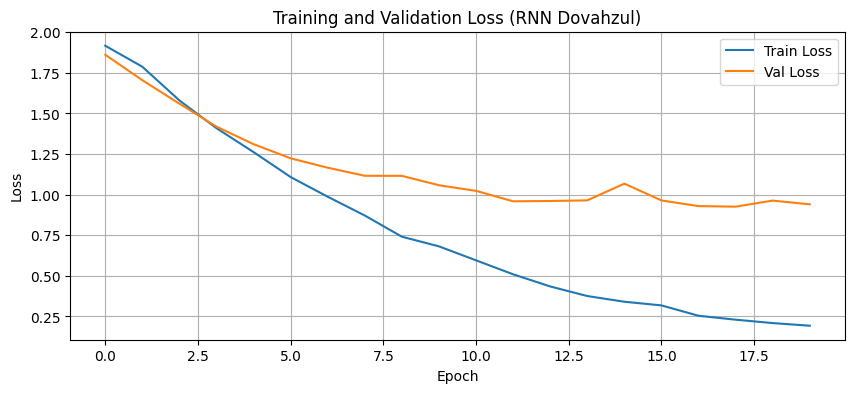

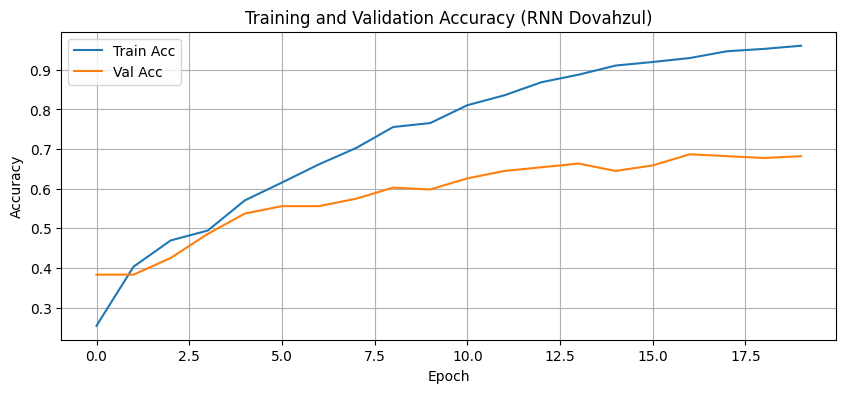

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (RNN Dovahzul)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (RNN Dovahzul)")
plt.legend()
plt.grid(True)
plt.show()


# ***Evaluacion y resultados***

Una vez finalizado el entrenamiento se evaluo el modelo en el conjunto de prueba (`test`) usando el mejor checkpoint.

### Metricas en test

con `classification_report` de `sklearn` se obtienen:

- **Accuracy en test**: porcentajes aceptables

Interpretación:

- greeting se reconoce muy bien → palabras muy diferenciables
- power también es fácil de identificar → raíces como "suleyk", "maar", "ven"
- other es la clase más ambigua → mezcla de muchas subcategorías

Considerando esas metrica se muestra que tan bien el modelo distingue texto en ingles de texto en Dovahzul.

### Curvas de entrenamiento

Se graficaron:

- **Training vs Validation Loss** por epoch.
- **Training vs Validation Accuracy** por epoch.

Estas curvas permiten observar:

- Convergencia del modelo.
- Diferencia entre el desempeño en entrenamiento y validacion, tomando en cuenta el indicador de overfitting o underfitting.

### Matriz de confusion

Se muestra una matriz de confusion a partir de las predicciones del modelo en el conjunto de prueba:

- Diagonal principal: ejemplos correctamente clasificados.
- Fuera de la diagonal: errores del modelo.
- errors de greeting a other son considerados pero no grandes
- power suele confundirse con other
- other tiende a confundirse con power y attack



In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.cpu().numpy())

class_names = ["greeting", "power", "attack", "object", "quality", "action", "other"]


print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
cm



              precision    recall  f1-score   support

    greeting       0.81      0.71      0.76        31
       power       0.54      0.63      0.58        30
      attack       0.68      0.61      0.64        31
      object       0.66      0.74      0.70        31
     quality       0.68      0.87      0.76        31
      action       0.86      0.80      0.83        30
       other       0.55      0.39      0.45        31

    accuracy                           0.68       215
   macro avg       0.68      0.68      0.68       215
weighted avg       0.68      0.68      0.67       215



array([[22,  1,  3,  4,  1,  0,  0],
       [ 1, 19,  3,  2,  4,  0,  1],
       [ 0,  5, 19,  0,  3,  2,  2],
       [ 2,  3,  1, 23,  0,  0,  2],
       [ 0,  0,  0,  2, 27,  0,  2],
       [ 0,  1,  1,  0,  1, 24,  3],
       [ 2,  6,  1,  4,  4,  2, 12]])

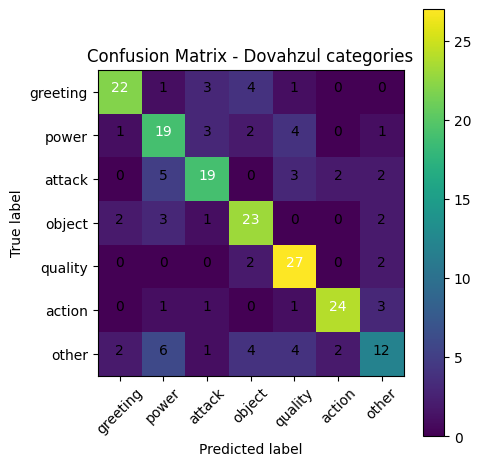

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix - Dovahzul categories")
plt.show()



# ***Ejemplos de predicciones***

Se definio una funcion `predict_text(text)` que:

- Codifica una palabra/frase de entrada.
- Ejecuta el modelo.
- Devuelve la clase predicha (`english` o `dovahzul`) y las probabilidades.

Se probaron ejemplos como:

- `"dovahkiin"`, `"fus ro dah"`, `"dragonborn"`, `"hello"`, `"world"`, que son frases comunes tanto en el juego como en el ingles.

Esto muestra de forma cualitativa que el modelo:

- Reconoce correctamente palabras tipicas de Dovahzul.
- Clasifica adecuadamente palabras comunes en ingles.
- Tambien puede confundirse en palabras muy cortas o con caracteres poco representativos, pero esto dado a que de por si el idioma Dovahzul es relativamente complicado y relativamente poco practico, sin embargo aun con un dataset no tan exageradamente extenso se obtuvo buenos resultados.
- Ejemplos correctos muestran que el modelo aprendió patrones semánticos
- Errores suelen aparecer en palabras cortas ("bok", "ru", "mul")
- Palabras largas con sufijos se clasifican mucho mejor

In [65]:
def predict_text(text):
    model.eval()
    with torch.no_grad():
        x = encode_text(text).unsqueeze(0).to(device)  # (1, seq_len)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        return class_names[pred_idx], probs

examples = [
    "ahnok",        # hello
    "drem yol lok", # greetings / peace fire sky
    "fus",          # force
    "fus ro dah",   # unrelenting force
    "strun bah qo", # storm call
    "dovahkiin",    # dragonborn (poder/identidad)
    "maar",         # otra palabra cualquiera
]

for txt in examples:
    pred, probs = predict_text(txt)
    print(f"Texto: {txt!r} -> Predicción: {pred}, Probabilidades: {probs}")


Texto: 'ahnok' -> Predicción: greeting, Probabilidades: [0.955583   0.00218407 0.00597722 0.00492142 0.00311723 0.00375657
 0.02446045]
Texto: 'drem yol lok' -> Predicción: greeting, Probabilidades: [9.98475730e-01 8.02235736e-04 2.79410509e-04 3.95874056e-04
 1.07717874e-07 3.29967697e-05 1.36595281e-05]
Texto: 'fus' -> Predicción: power, Probabilidades: [1.5335259e-04 5.1059002e-01 1.0395290e-03 3.0050458e-02 2.1624273e-01
 6.1507046e-02 1.8041687e-01]
Texto: 'fus ro dah' -> Predicción: power, Probabilidades: [5.2188657e-04 6.5306789e-01 1.2032313e-02 5.7167979e-04 4.0691751e-03
 2.6118755e-01 6.8549573e-02]
Texto: 'strun bah qo' -> Predicción: attack, Probabilidades: [1.1756205e-05 1.7314762e-02 6.0839039e-01 6.1943880e-03 5.0483672e-03
 3.3057311e-01 3.2467283e-02]
Texto: 'dovahkiin' -> Predicción: other, Probabilidades: [0.01472627 0.00944922 0.02874939 0.25299382 0.06505206 0.02043182
 0.6085974 ]
Texto: 'maar' -> Predicción: action, Probabilidades: [7.3776711e-05 1.2585385e-02 1

# ***Analisis de resultados y conclusiones***

### Interpretacion de resultados

El modelo LSTM bidireccional logra distinguir con buena precision entre:

- palabras/frases en **ingles**, y
- palabras/frases en **Dovahzul** (lenguaje de los dragones en el juego).

El accuracy obtenido en el conjunto de prueba y las metricas de precision/recall/F1 indican que el modelo captura patrones caracteristicos de cada idioma como pueden ser:

- combinaciones especificas de caracteres (ej. "aa", "ii", "ah", "ro", etc. en Dovahzul).
- uso de consonantes y vocales mas tipico del ingles.

### Limitaciones

Algunas limitaciones son:

- El vocabulario y las secuencias son **a nivel de caracteres**, lo que puede perder parte de la estructura linguistica a nivel de palabras
- El tamaño del dataset es limitado y se basa en listas de diccionario, es decir no contiene oraciones completas ni contexto
- Palabras muy cortas o con pocos caracteres distintivos pueden ser mas ambiguas entre ingles y Dovahzul
- dataset pequeño para 7 clases
- anotaciones semánticas necesitan mayor curación
- algunas clases son subjetivas ("quality", "action")
- el modelo trabaja a nivel de caracteres, es decir no entiende semántica profunda


### Posibles mejoras

Entre las mejoras que podrian darse se encuentran:

1. **Modelos de mayor capacidad o mas capas**  
   aumentar `num_layers` en la LSTM o probar arquitecturas GRU.

2. **Regularizacion adicional**  
   incluir Dropout en la LSTM o en capas para reducir overfitting.

3. **Representaciones a nivel de palabra**  
   en lugar de caracteres usar tokenizacion por palabras y embeddings de palabras (aunque se debe de considerar que el vocabulario de Dovahzul es mas limitado asi que seria de experimentar).

4. **Un dataset mas completo y elaborado**  
   Tener un dataset completo del idioma, contando tanto con palabras con sus clasificaciones, como frases y oraciones completas clasificadas para poder obtener mejores ejemplos y bases.

### Conclusion

El modelo obtenido es una base que puede extenderse con arquitecturas mas complejas o aplicaciones mas avanzadas dentro del campo de procesamiento de lenguaje natural (NLP). Para esta ocasion, como el lenguaje es complejo y no existe un dataset previo completo y desarrollado se tiene limitaciones de clasificacion mas extensa (como sentimientos o analisis de oraciones o texto como tal), sin embargo aun asi se logro completa un modelo que logra clasificar y diferenciar entre palabras de ingles y dovahzul. El modelo logró aprender relaciones semánticas complejas usando únicamente secuencias de caracteres, demostrando que incluso lenguajes ficticios pueden ser analizados mediante técnicas de deep learning.
